<a href="https://colab.research.google.com/github/vigneshiitm/kaggle_helpers/blob/main/bone_dilated_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet to predict bone layer on chest X-rays

Reference: https://www.kaggle.com/raddar/bone-drr-unet

We are going to use **synthetically** generated X-rays in the form of CT DRR to train UNet model with perception loss. The dataset https://www.kaggle.com/raddar/digitally-reconstructed-radiographs-drr-bones will be used in further experiments.

Digitally Reconstructed Radiograph (DRR) is a novel approach to generate synthetic chest X-rays (CXR) from real CT scan data. Although real data was used, I am using term **synthetic**, as the DRR images were generated in a process described with parametric model (more on that: https://arxiv.org/pdf/2003.10839.pdf). The parameters were selected to pass the human eye test - if the generated image resembles appearance of a real chest X-ray. Moreover, the synthetic images would be considered too blurry and of very low quality compared to X-rays taken with standard X-ray devices.

Although DRR has obvious drawbacks, it can make use of most of the good stuff coming from CT scans, like bones, soft tissue, organs, etc. can be easily separated.

This notebook was an interesting weekend project for me to explore, if chest CT scan data can yield a model suitable for chest X-ray modality. It could also solve some tasks such as segmenting the ribs and other bones - which is a very tedious task to hand label on chest X-rays.


## Data preparation

Let's read the images and put image paths into workable pandas format:

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K


files = []
for dirname, _, filenames in os.walk('/kaggle/input/digitally-reconstructed-radiographs-drr-bones'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

bone_drr = pd.DataFrame([(x, x.replace('.png','_mask.png')) for x in files if not x.endswith('_mask.png')])
bone_drr.columns = ['image','bones']

print(f'Total instances: {bone_drr.shape[0]}')

Total instances: 193


Let's output some example images:

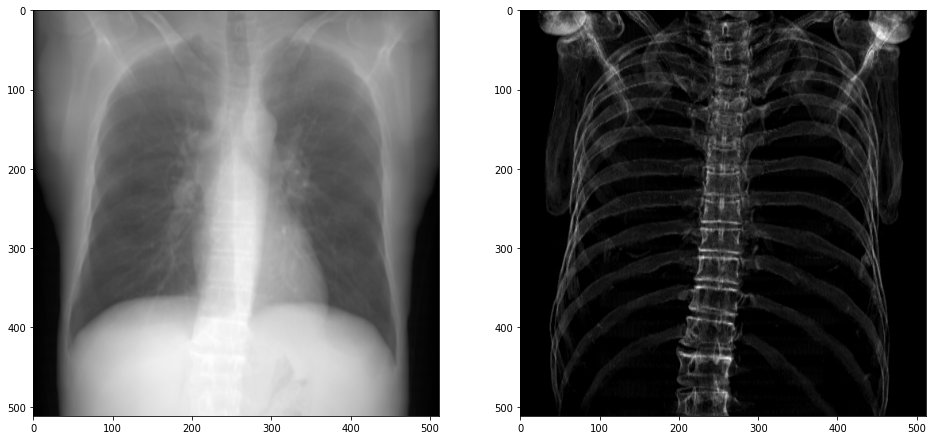

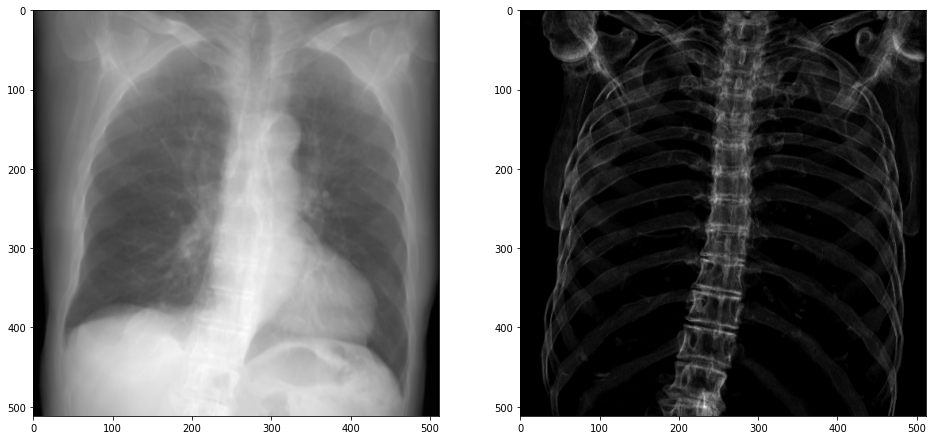

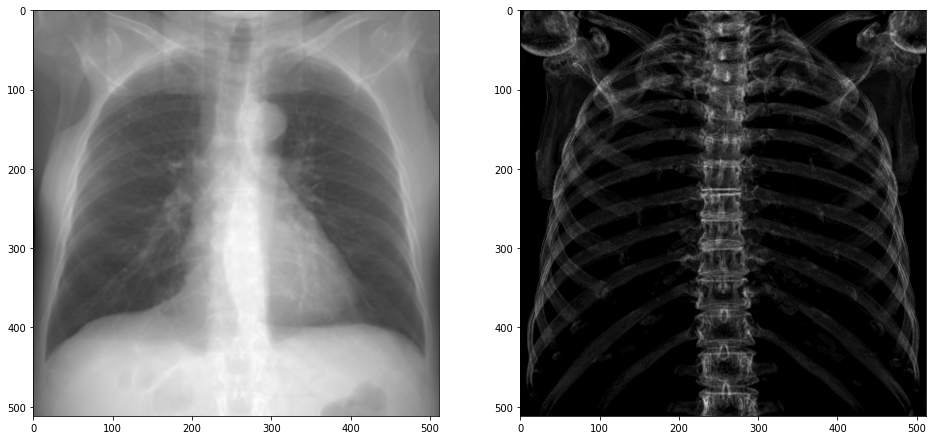

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(cv2.imread(bone_drr.image[20], 0), 'gray')
axes[1].imshow(cv2.imread(bone_drr.bones[20], 0), 'gray')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(cv2.imread(bone_drr.image[40], 0), 'gray')
axes[1].imshow(cv2.imread(bone_drr.bones[40], 0), 'gray')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(cv2.imread(bone_drr.image[60], 0), 'gray')
axes[1].imshow(cv2.imread(bone_drr.bones[60], 0), 'gray')

The chest X-ray image looks too blurry to be considered a standard X-ray. Other than that, it is a nice looking image with no artifacts. As for bone mask layer - it appears only bone tissue is visualized - this is what we want to predict on a regular chest X-ray!

So, we have almost 200 images to work with. It seems like not much, but the images are heavily standardized, thus it may be possible for a network to learn something here. Fingers crossed!

Time to train something!


## UNet + dilated convolutions + perception loss

The analyzed paper (https://arxiv.org/pdf/2003.10839.pdf) used standard UNet model with dilated convolutions. Let's take one, shamelessly taken from https://github.com/GlastonburyC/Dilated-U-net/blob/master/dilatedUnet.py.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    Conv2DTranspose,
    Lambda,
    Reshape,
    add,
)
import tensorflow.keras.backend as K


def dilated_unet(im_shape, addition=1, dilate=1, dilate_rate=1):
    x = inputs = Input(im_shape)

    down1 = Conv2D(
        44, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(x)
    down1 = Conv2D(
        44,
        3,
        activation="relu",
        padding="same",
        dilation_rate=dilate_rate,
        kernel_initializer="he_normal",
    )(x)
    down1pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    down2 = Conv2D(
        88, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(down1pool)
    down2 = Conv2D(
        88,
        3,
        activation="relu",
        padding="same",
        dilation_rate=dilate_rate,
        kernel_initializer="he_normal",
    )(down1pool)
    down2pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    down3 = Conv2D(
        176, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(down2pool)
    down3 = Conv2D(
        176,
        3,
        activation="relu",
        padding="same",
        dilation_rate=dilate_rate,
        kernel_initializer="he_normal",
    )(down3)
    down3pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    if dilate == 1:
        # stacked dilated convolution at the bottleneck
        dilate1 = Conv2D(
            176,
            3,
            activation="relu",
            padding="same",
            dilation_rate=1,
            kernel_initializer="he_normal",
        )(down3pool)
        dilate2 = Conv2D(
            176,
            3,
            activation="relu",
            padding="same",
            dilation_rate=2,
            kernel_initializer="he_normal",
        )(dilate1)
        if addition == 1:
            dilate_all_added = add([dilate1, dilate2])
            up3 = UpSampling2D((2, 2))(dilate_all_added)
        else:
            up3 = UpSampling2D((2, 2))(dilate2)
    up3 = Conv2D(
        88, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up3)
    up3 = concatenate([down3, up3])
    up3 = Conv2D(
        88, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up3)
    up3 = Conv2D(
        88, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = Conv2D(
        44, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up2)
    up2 = concatenate([down2, up2])
    up2 = Conv2D(
        44, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up2)
    up2 = Conv2D(
        44, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = Conv2D(
        22, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up1)
    up1 = concatenate([down1, up1])
    up1 = Conv2D(
        22, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up1)
    up1 = Conv2D(
        22, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(up1)
    x = Conv2D(1, 1, activation="tanh")(up1)
    net = Model(inputs=inputs, outputs=x)
    return net

Slight modifications were made - most importantly output layer activation function set to `tanh`. Typically, UNet is trained on binary masks, but there is no restriction for us to train pixel wise regression! If you looked at our bone masks again - pixels are not binary!

Now time to define a data generator, which again is shamelessly taken from https://github.com/imlab-uiip/lung-segmentation-2d.
As the repository was quite old, some modifications were made to meet with `tensorflow.keras` framework.

In [ ]:
"""Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
"""
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading
import warnings
import cv2

from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence

try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None


def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.pi / 180 * np.random.uniform(-rg, rg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shear of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Sheared Numpy image tensor.
    """
    shear = np.random.uniform(-intensity, intensity)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):
    """Performs a random spatial zoom of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Zoomed Numpy image tensor.

    # Raises
        ValueError: if `zoom_range` isn't a tuple.
    """
    if len(zoom_range) != 2:
        raise ValueError('zoom_range should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_channel_shift(x, intensity, channel_axis=0):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.

    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].

    # Returns
        A PIL Image instance.

    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.

    # Arguments
        img: PIL Image instance.
        data_format: Image data format.

    # Returns
        A 3D Numpy array.

    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x


def load_img(path, grayscale=False, target_size=None):
    """Loads an image into PIL format.

    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.

    # Returns
        A PIL Image instance.

    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img


def list_pictures(directory, ext='jpg|jpeg|bmp|png'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]


class ImageDataGenerator(object):
    """Generate minibatches of image data with real-time data augmentation.

    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        rotation_range: degrees (0 to 180).
        width_shift_range: fraction of total width.
        height_shift_range: fraction of total height.
        shear_range: shear intensity (shear angle in radians).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channels.
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally.
        vertical_flip: whether to randomly flip images vertically.
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run before any other modification on it.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
            (the depth) is at index 1, in 'channels_last' mode it is at index 3.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('data_format should be "channels_last" (channel after row and '
                             'column) or "channels_first" (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('zoom_range should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.

        # Arguments
            x: batch of inputs to be normalized.

        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) + 1e-7)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (x.size))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, y):
        """Randomly augment a single image tensor + image mask.

        # Arguments
            x: 3D tensor, single image.
            y: 3D tensor, image mask.

        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)
            y = apply_transform(y, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
            y = random_channel_shift(y,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)
                y = flip_axis(y, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)
                y = flip_axis(y, img_row_axis)

        ### put random R or L letters
        if np.random.random() < 0.5:
            t = np.zeros(x.shape).astype(np.uint8)
            adj1 = int((np.random.random() - 0.5) * 20)
            adj2 = int((np.random.random() - 0.5) * 20)      
            col = np.max(x)    
            t = cv2.putText(img=t, text="R", org=(50+adj1,50+adj2),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX , fontScale=1, color=[255, 255, 255], thickness=2)
            x[t>0] = np.max(x) 

        if np.random.random() < 0.5:
            t = np.zeros(x.shape).astype(np.uint8)
            adj1 = int((np.random.random() - 0.5) * 20)
            adj2 = int((np.random.random() - 0.5) * 20)      
            col = np.max(x)    
            t = cv2.putText(img=t, text="L", org=(450+adj1,50+adj2),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX , fontScale=1, color=[255, 255, 255], thickness=2)
            x[t>0] = np.max(x)

        return x, y

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.

        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.

        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.

        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            raise ValueError(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]], _ = self.random_transform(x[i], x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + 10e-7))), u.T)


class Iterator(Sequence):
    """Abstract base class for image data iterators.

    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.

    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='jpeg'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            raise ValueError('NumpyArrayIterator is set to use the '
                             'data format convention "' + data_format + '" '
                             '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                             'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                             'However, it was passed an array with shape ' + str(self.x.shape) +
                             ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.shape = x.shape
        self.batch_size = batch_size
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)


    def __len__(self):
        """Denotes the number of batches per epoch"""
        if len(self.x) % self.batch_size == 0:
            self.epoch_size = len(self.x) // self.batch_size
        else:
            self.epoch_size = len(self.x) // self.batch_size + 1
        return self.epoch_size

    def __getitem__(self, _):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x_shape = [current_batch_size] + list(self.x.shape)[1:]
        batch_x_shape = tuple(batch_x_shape)
        batch_x = np.zeros(batch_x_shape, dtype=K.floatx())
        batch_y = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            y = self.y[j]
            x, y = self.image_data_generator.random_transform(x.astype(K.floatx()), y.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = y

        if self.save_to_dir:
            for i in range(current_batch_size):
                imgx = array_to_img(batch_x[i], self.data_format, scale=True)
                imgy = array_to_img(batch_y[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                imgx.save(os.path.join(self.save_to_dir, 'x_' + fname))
                imgy.save(os.path.join(self.save_to_dir, 'y_' + fname))
        if self.y is None:
            return batch_x
        return batch_x, batch_y

Some contribution was made to synthetically generate "R" and "L" letters on the left upper and right upper corners - this can be seen in most chest X-rays. So our synthetic X-rays will get some prior knowledge about how real X-rays look like!

## Training UNet

Before start training something, let's look at the proposed loss function to use during training.
As the training sample is quite small, standard loss functions like MSE or RMSE on pixel level not necessarily translates to good looking bone mask predictions - this was also observed in the paper. Perception loss was introduced - which is a very interesting concept.

The idea of perception loss is to compare feature maps of proxy model, providing original input (bone mask) and predicted output (predicted bone mask by UNet) - and calculating difference between them. The smaller overall mean difference - the more conceptually similar original and predicted images are! 

Moreover, perceptual loss helps us somewhat deal with data being synthetic, as model focuses less on overfitting to the blurry synthetic data we have. This is important for our task - transfer the model to real X-rays.

Let's use good old VGG19 model and take one of its layers as a perception vector:

In [ ]:
#tensorflow 2.1 error
#ValueError: tf.function-decorated function tried to create variables on non-first call
#temporary workaround...
tf.compat.v1.disable_eager_execution()

def perceptual_loss_vgg19(y_true, y_pred):
    # must ensure that y_true and y_pred come from same distribution
    # nice to have - similar distribution to vgg19 inputs
    y_pred = tf.image.grayscale_to_rgb(y_pred, name=None) #need to convert as UNet outputs single channel
    vgg = VGG19(include_top=False, weights="imagenet", input_shape=(512, 512, 3))
    loss_model = Model(
        inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output
    )
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

Finally, we can load the data and train the model. 

In [ ]:
def load_data(df, im_shape):
    X, y = [], []
    for i, item in df.iterrows():
        img = cv2.imread(item[0], 0)
        img = cv2.resize(img, im_shape[:2])
        img = img.astype(np.float32)
        img -= img.mean()
        img /= img.std()
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        mask = cv2.imread(item[1]) / 255
        mask = cv2.resize(mask, im_shape[:2])
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    return X, y


# Shuffle rows in dataframe. Random state is set for reproducibility.
bone_drr = bone_drr.sample(frac=1, random_state=23)
df_train = bone_drr[:160].reset_index(drop=True)
df_val = bone_drr[160:].reset_index(drop=True)

# Load training and validation data
im_shape = (512, 512, 3)
X_train, y_train = load_data(df_train, im_shape)
X_val, y_val = load_data(df_val, im_shape)

In [ ]:
UNet = dilated_unet(im_shape)
UNet.compile(optimizer="adam", loss=perceptual_loss_vgg19, metrics=[perceptual_loss_vgg19])

model_file_format = "model_dilated_unet512_vgg19.{epoch:03d}.hdf5"
checkpointer = ModelCheckpoint(model_file_format, period=10)

train_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1.0,
    zoom_range=0.2,
    fill_mode="nearest",
    cval=0,
)

test_gen = ImageDataGenerator(rescale=1.0)

batch_size = 4
train_steps_per_epoch = (df_train.shape[0] + batch_size - 1) // batch_size
val_steps_per_epoch = (df_val.shape[0] + batch_size - 1) // batch_size

UNet.fit_generator(
    train_gen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    callbacks=[checkpointer],
    validation_data=test_gen.flow(X_val, y_val, batch_size=batch_size),
    validation_steps=val_steps_per_epoch,
)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
160/160 [==============================] - 34s 211ms/sample - loss: 10.0770 - perceptual_loss_vgg19: 10.0770 - val_loss: 8.0534 - val_perceptual_loss_vgg19: 8.0534
Epoch 2/100
160/160 [==============================] - 29s 181ms/sample - loss: 7.0294 - perceptual_loss_vgg19: 7.0294 - val_loss: 7.0727 - val_perceptual_loss_vgg19: 7.0727
Epoch 3/100
160/160 [==============================] - 29s 181ms/sample - loss: 6.4404 - perceptual_loss_vgg19: 6.4404 - val_loss: 6.3712 - val_perceptual_loss_vgg19: 6.3712
Epoch 4/100
160/160 [==============================] - 29s 182ms/sample - loss: 6.0204 - perceptual_loss_vgg19: 6.0204 - val_loss: 6.5177 - val_perceptual_loss_vgg19: 6.5177
Epoch 5/100
160/160 [==============================] - 29s 179ms/sample - loss: 5.8812 - perceptual_loss_vgg19: 5.8812 - val_loss: 6.0844 - val_perceptual_loss_vgg19: 6.0844
Epoch 6/100
160/160 [==============================] - 29s 182m

## Model evaluation

It would not make any sense to validate on the validation split of our model. So let's just take a few chest X-ray samples from open datasets. I chose PadChest, but you can use any other - I have collected quite a few datasets (please be sure to check my profile :))

Let's define our model class and load weights:

In [ ]:
from tensorflow.keras.models import load_model

class BoneSegmentation:

    def __init__(self, model_path, input_shape):
        self.unet = load_model(model_path, compile=False)
        self.input_shape = input_shape
        self.datagen = ImageDataGenerator(rescale=1.0)

    def preprocess_image(self, img, unet_input_shape):
        img = cv2.resize(img, unet_input_shape[:2])
        img = img.astype(np.float32)
        img -= img.mean()
        img /= img.std()
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = np.array(img)
        return img

    def predict(self, image):
        img = self.preprocess_image(image, self.input_shape)
        pred = self.unet.predict(np.expand_dims(np.array(img), 0))[0, :, :, 0]
        pred[pred < 0] = 0
        return pred
    
model = BoneSegmentation('/kaggle/working/model_dilated_unet512_vgg19.100.hdf5', input_shape=(512, 512, 3))

Read the file list:

In [ ]:
padchest = []
for dirname, _, filenames in os.walk('/kaggle/input/padchest-chest-xrays-sample/sample'):
    for filename in filenames:
        padchest.append(os.path.join(dirname, filename))

And finally visualizations!

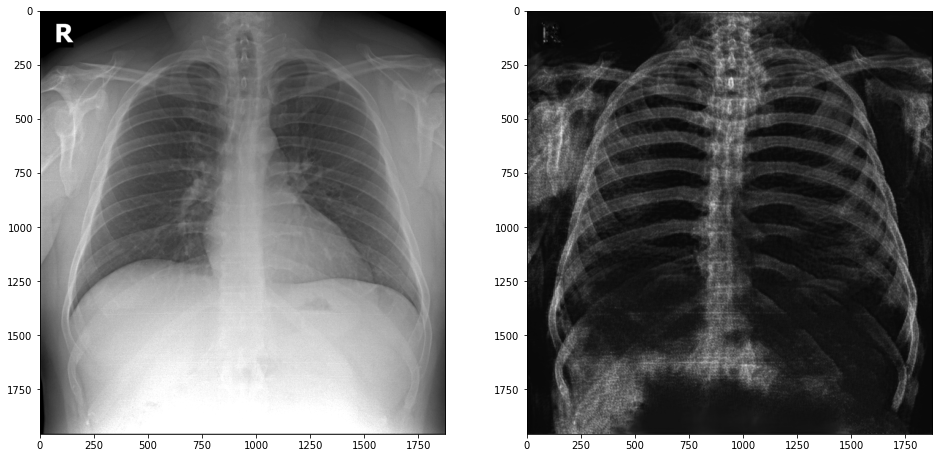

In [ ]:
img = cv2.imread('/kaggle/input/padchest-chest-xrays-sample/sample/216840111366964012819207061112010316094555679_04-017-068.png', 0)
pred = model.predict(img)
pred = cv2.resize(pred, (img.shape[1], img.shape[0]))
pred = pred - np.min(pred)
pred = (pred / np.max(pred) * 255).astype(np.uint8)    

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(img, 'gray')
axes[1].imshow(pred, 'gray')

To be honest - this is beyond my expectations! We used something synthetic and it performs very well on a real task! 
Having an option to easily switch on/off bone view in chest X-rays could help radiologists to quickly spot fractures - it is really easy to miss them if you are tired/not focused enough. From my experience, fractures is one of the hardest tasks for radiologists (and deep learning models as well) - so this could be useful.


Let's see how predicted bone mask overlays original image:

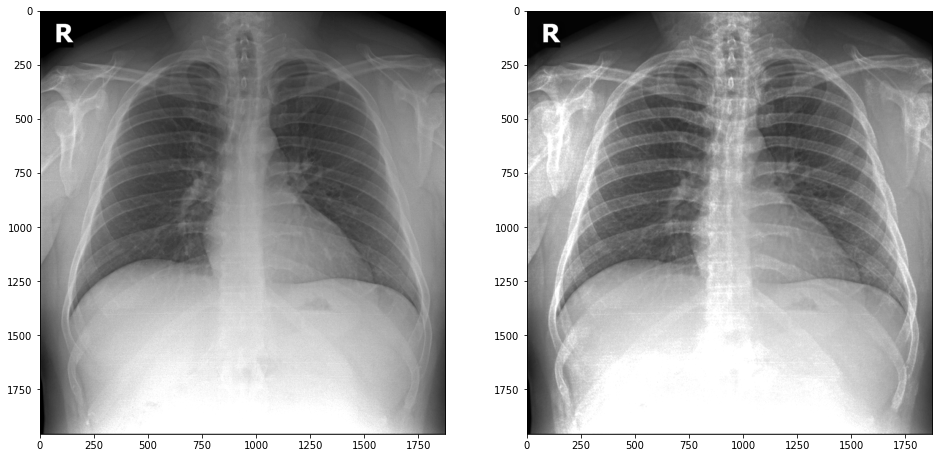

In [ ]:
merge = cv2.addWeighted(img, 1, pred, 0.4, 0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(img, 'gray')
axes[1].imshow(merge, 'gray')

Bones are more well defined!

Silly attempt to remove ribs:

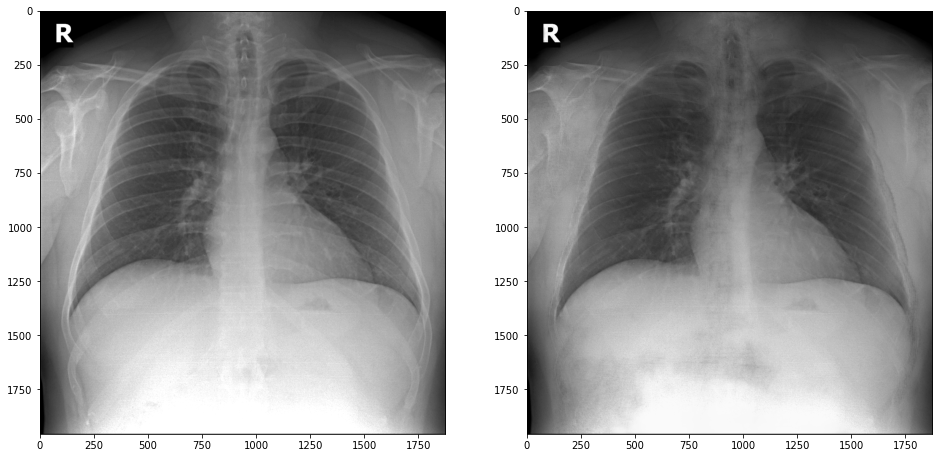

In [ ]:
merge = cv2.addWeighted(img, 1, pred, -0.3, 0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(img, 'gray')
axes[1].imshow(merge, 'gray')

It seems rib removal is a harder task. I guess the framework can be easily adjusted for that, but maybe for the next time!

## Results

3D CT scan transformations to 2D chest X-ray representations are useful to make models suitable for 2D X-ray modality. It has been shown, that such models are capable of segmentation of specific parts of chest with given limited amount of data.